# Twitter Sentiment Analysis

In [13]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import re
import emoji

# Download necessary NLTK data
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt')
nltk.download('stopwords')

# Set style for plots
plt.style.use('ggplot')
sns.set_palette('deep')

[nltk_data] Downloading package wordnet to /Users/ayman/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/ayman/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package punkt to /Users/ayman/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/ayman/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [14]:
# Load datasets
training_data = pd.read_csv('../data/twitter_training.csv')
validation_data = pd.read_csv('../data/twitter_validation.csv')

# Display the first few rows and basic info
print("Training Data:")
print(training_data.head())
print(training_data.info())

print("\nValidation Data:")
print(validation_data.head())
print(validation_data.info())

# Rename columns for consistency
training_data.columns = ['index', 'entity', 'sentiment', 'text']
validation_data.columns = ['index', 'entity', 'sentiment', 'text']

# Check for missing values
print("\nMissing values in Training Data:")
print(training_data.isnull().sum())
print("\nMissing values in Validation Data:")
print(validation_data.isnull().sum())

Training Data:
   2401  Borderlands  Positive  \
0  2401  Borderlands  Positive   
1  2401  Borderlands  Positive   
2  2401  Borderlands  Positive   
3  2401  Borderlands  Positive   
4  2401  Borderlands  Positive   

  im getting on borderlands and i will murder you all ,  
0  I am coming to the borders and I will kill you...     
1  im getting on borderlands and i will kill you ...     
2  im coming on borderlands and i will murder you...     
3  im getting on borderlands 2 and i will murder ...     
4  im getting into borderlands and i can murder y...     
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74681 entries, 0 to 74680
Data columns (total 4 columns):
 #   Column                                                 Non-Null Count  Dtype 
---  ------                                                 --------------  ----- 
 0   2401                                                   74681 non-null  int64 
 1   Borderlands                                            74681 non-null 

In [15]:
#---------------------------------------- Initialize lemmatizer -------------------------------------#
lemmatizer = WordNetLemmatizer()

#----------------------- text cleaning function -----------------------#
def improved_clean_text(text):
    if not isinstance(text, str):
        return ""
    
    # Convert emojis to text
    text = emoji.demojize(text)
    
    # Remove URLs, @mentions, and #hashtags (keeping the hashtag text)
    text = re.sub(r'http\S+', '', text)
    text = re.sub(r'@\w+', '', text)
    text = re.sub(r'#(\w+)', r'\1', text)
    
    # Convert to lowercase
    text = text.lower()
    
    # Remove punctuation and numbers
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\d+', '', text)
    
    # Tokenize
    tokens = nltk.word_tokenize(text)
    
    # Remove stopwords and lemmatize
    stop_words = set(stopwords.words('english'))
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    
    return ' '.join(tokens)

#----------------------- text cleaning -----------------------#
training_data['cleaned_text'] = training_data['text'].apply(improved_clean_text)
validation_data['cleaned_text'] = validation_data['text'].apply(improved_clean_text)

#----------------------- Display a few cleaned tweets -----------------------#
print("Sample cleaned tweets:")
print(training_data[['text', 'cleaned_text']].head())

Sample cleaned tweets:
                                                text  \
0  I am coming to the borders and I will kill you...   
1  im getting on borderlands and i will kill you ...   
2  im coming on borderlands and i will murder you...   
3  im getting on borderlands 2 and i will murder ...   
4  im getting into borderlands and i can murder y...   

                   cleaned_text  
0            coming border kill  
1    im getting borderland kill  
2   im coming borderland murder  
3  im getting borderland murder  
4  im getting borderland murder  


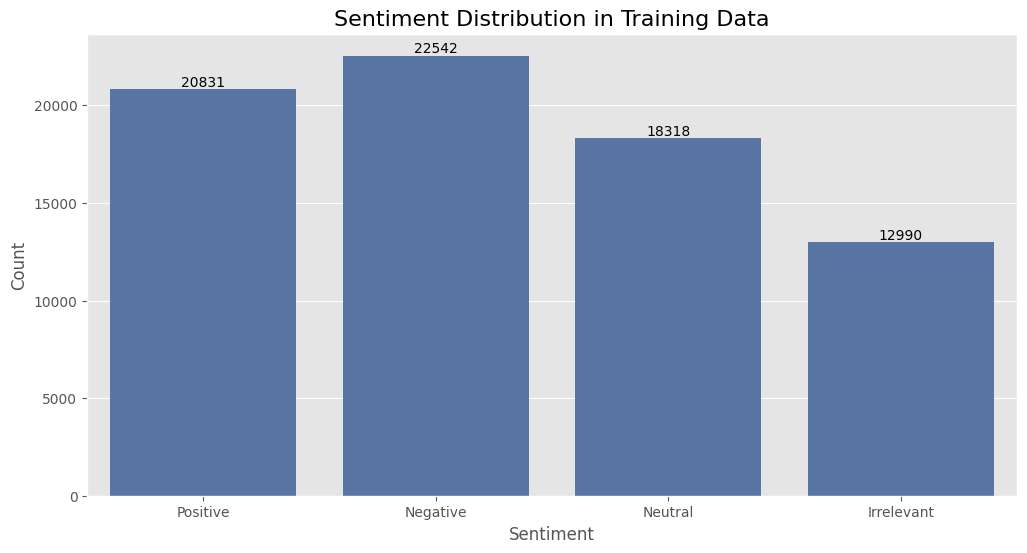

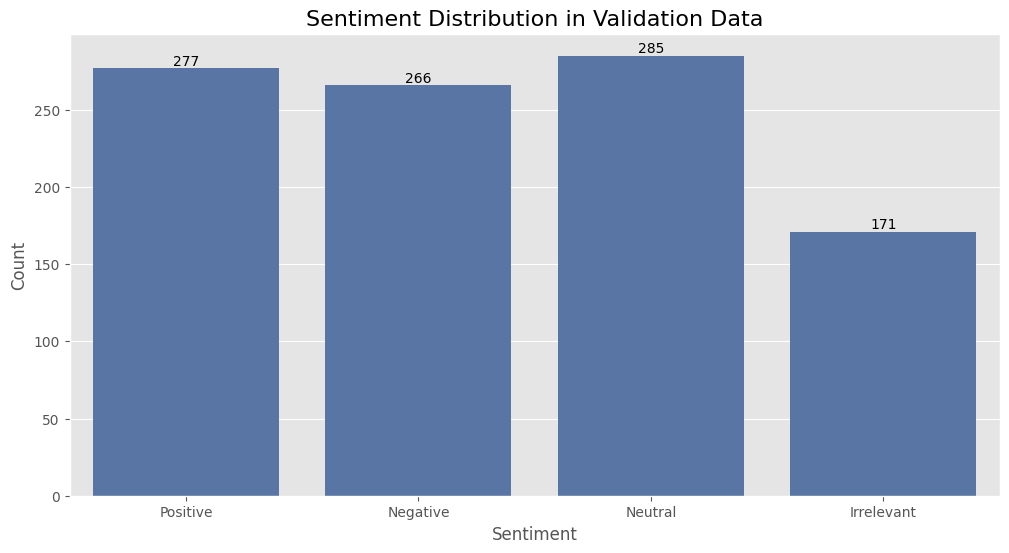

In [16]:
################################# Function to plot sentiment distribution
def plot_sentiment_distribution(data, title):
    plt.figure(figsize=(12, 6))
    sns.countplot(x='sentiment', data=data, order=['Positive', 'Negative', 'Neutral', 'Irrelevant'])
    plt.title(title, fontsize=16)
    plt.xlabel('Sentiment', fontsize=12)
    plt.ylabel('Count', fontsize=12)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    for i in plt.gca().containers:
        plt.gca().bar_label(i)
    plt.show()

################################# Plot sentiment distribution for training data
plot_sentiment_distribution(training_data, 'Sentiment Distribution in Training Data')

################################# Plot sentiment distribution for validation data
plot_sentiment_distribution(validation_data, 'Sentiment Distribution in Validation Data')

In [17]:
################################# Prepare data for modeling ###############################
X = training_data['cleaned_text']
y = training_data['sentiment']

################################# Split the data ##########################################
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

################################# Create TF-IDF features with expanded n-grams ############
vectorizer = TfidfVectorizer(max_features=10000, ngram_range=(1, 3))
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

################################# Apply SMOTE for oversampling ############################
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_tfidf, y_train)

################################# Create an ensemble of models ############################
svm = LinearSVC(class_weight='balanced')
nb = MultinomialNB(alpha=0.5)
rf = RandomForestClassifier(n_estimators=200, max_depth=20, class_weight='balanced', random_state=42)

ensemble = VotingClassifier(
    estimators=[('svm', svm), ('nb', nb), ('rf', rf)],
    voting='hard'
)

################################# Perform cross-validation #################################
cv_scores = cross_val_score(ensemble, X_train_resampled, y_train_resampled, cv=5)
print(f"Cross-validation scores: {cv_scores}")
print(f"Mean CV score: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")

################################# Train the ensemble ########################################
ensemble.fit(X_train_resampled, y_train_resampled)

# Make predictions
y_pred = ensemble.predict(X_test_tfidf)

################################# Print classification report ################################
print(classification_report(y_test, y_pred))

Cross-validation scores: [0.71522446 0.71238846 0.72366328 0.73265546 0.74771721]
Mean CV score: 0.7263 (+/- 0.0256)
              precision    recall  f1-score   support

  Irrelevant       0.51      0.74      0.60      2661
    Negative       0.77      0.75      0.76      4471
     Neutral       0.75      0.59      0.66      3551
    Positive       0.77      0.71      0.74      4254

    accuracy                           0.70     14937
   macro avg       0.70      0.70      0.69     14937
weighted avg       0.72      0.70      0.70     14937



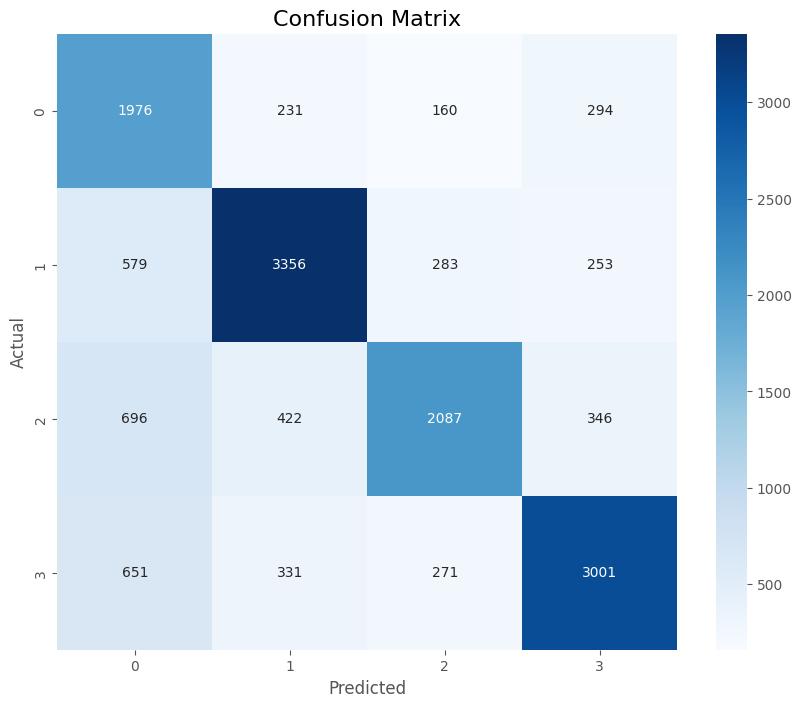

In [18]:
################################# Plot confusion matrix #################################
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix', fontsize=16)
plt.xlabel('Predicted', fontsize=12)
plt.ylabel('Actual', fontsize=12)
plt.show()

In [19]:
# Error analysis
misclassified = X_test[y_test != y_pred]
misclassified_sentiments = y_test[y_test != y_pred]
misclassified_predictions = y_pred[y_test != y_pred]

print("\nSample of misclassified tweets:")
for i in range(min(10, len(misclassified))):
    print(f"Text: {misclassified.iloc[i]}")
    print(f"True Sentiment: {misclassified_sentiments.iloc[i]}")
    print(f"Predicted Sentiment: {misclassified_predictions[i]}")
    print()


Sample of misclassified tweets:
Text: one
True Sentiment: Positive
Predicted Sentiment: Irrelevant

Text: verizon shed digital tv blackcutting escalates breitbartcomentertainment black internet verizon gave way cokeshow money verizon keep cutting ch
True Sentiment: Neutral
Predicted Sentiment: Negative

Text: tmmobile guy slow town tuba
True Sentiment: Positive
Predicted Sentiment: Negative

Text: internet mad dame getting regular cover like kobe get legend editionunkunk disrespect yall showed dame wild simpleton lol
True Sentiment: Neutral
Predicted Sentiment: Positive

Text: here montage rescuing teammate spreadlovehxly time day
True Sentiment: Positive
Predicted Sentiment: Irrelevant

Text: name favorite video game assassin creed revelation film captain america winter solider book touching spirit bear manga dont read manga television series smallville superhero daredevil anime hero academia
True Sentiment: Irrelevant
Predicted Sentiment: Positive

Text: also received amazon evouche